# 20.05 Challenge: Model Comparison

### Assignment:

You now know two kinds of regression and two kinds of classifier. So let's use that to compare models!

Comparing models is something data scientists do all the time. There's very rarely just one model that would be possible to run for a given situation, so learning to choose the best one is very important.

Here let's work on regression. Find a data set and build a KNN Regression and an OLS regression. Compare the two. How similar are they? Do they miss in different ways?

Create a Jupyter notebook with your models. At the end in a markdown cell write a few paragraphs to describe the models' behaviors and why you favor one model or the other. Try to determine whether there is a situation where you would change your mind, or whether one is unambiguously better than the other. Lastly, try to note what it is about the data that causes the better model to outperform the weaker model. Submit a link to your notebook below.

### Solution:

In [198]:
import numpy as np 
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import matthews_corrcoef
from statsmodels.tools.eval_measures import mse, rmse

In [17]:
# Get the data from the State of Texas: https://data.texas.gov/Business-and-Economy/Bid-Book-Spreadsheet-2017/qwhy-c2kk/data
bidbook = pd.read_csv("Bid_Book_Spreadsheet_2017.csv")

# Get the columns that are being worked with
bidbook2 = bidbook[["Category","Quantity","Estimated Worth"]].copy()

# No EDA here just grab some data to work with, drop all extraenous nulls
bidbook2 = bidbook2[
    (~bidbook["Estimated Worth"].isnull()) & 
    (~bidbook["Quantity"].isnull()) & 
    (~bidbook["Category"].isnull()) &
    (bidbook["Agency Number"]!="55555") &
    (bidbook["Quantity"]<1000) & 
    (bidbook["Estimated Worth"]<1000)]

# Take a look at the data you're left with
bidbook2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 19 to 1324
Data columns (total 3 columns):
Category           297 non-null object
Quantity           297 non-null float64
Estimated Worth    297 non-null float64
dtypes: float64(2), object(1)
memory usage: 9.3+ KB


In [18]:
# Create some dummy for the categorical data in "Category", only interested in the column for "cat_Office Supplies"
bids = pd.concat([bidbook2, pd.get_dummies(bidbook2["Category"], prefix="cat", drop_first=True)], axis=1)

# Check out the columns you've created
bids.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 19 to 1324
Data columns (total 9 columns):
Category                     297 non-null object
Quantity                     297 non-null float64
Estimated Worth              297 non-null float64
cat_Construction             297 non-null uint8
cat_IT                       297 non-null uint8
cat_Office Supplies          297 non-null uint8
cat_Other                    297 non-null uint8
cat_Other Services           297 non-null uint8
cat_Professional Services    297 non-null uint8
dtypes: float64(2), object(1), uint8(6)
memory usage: 11.0+ KB


In [88]:
# X is the feature set
X = bids[["Quantity","Estimated Worth"]]

# Y is the target variable 
Y = bids["cat_Office Supplies"]

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.2, random_state = 465)

# Add a constant to the model
X = sm.add_constant(X.to_numpy())

# Fit an OLS model using statsmodel 
results = sm.OLS(Y,X).fit()

# Add a constant for the test model 
X_test = sm.add_constant(X_test.to_numpy())

# Make predictions on this run 
y_preds = results.predict(X_test)



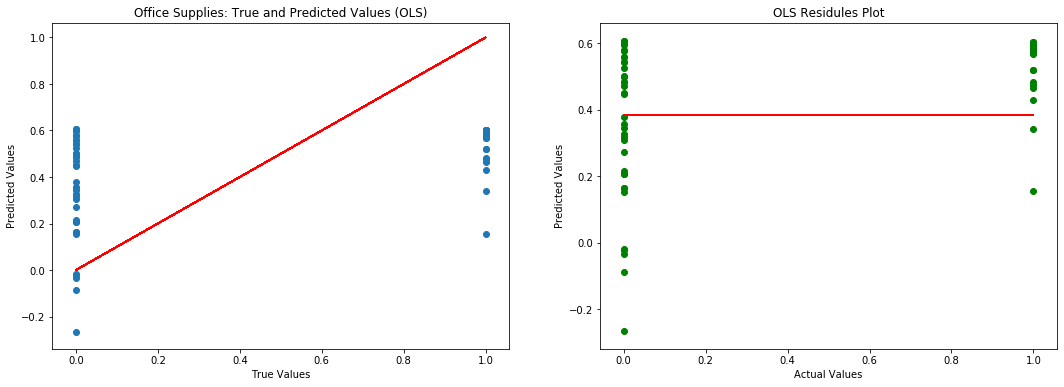

Mean Absolute Error (MAE) of the prediction is: 0.4140475220972071
Mean Squared Error (MSE) of the prediction is: 0.19857817031585748
Root Mean Squared Error (RMSE) of the prediction is: 0.4456211062279899
Mean Absolute Percentage Error (MAPE) of the prediciton is: inf
R-squared is: 0.22215938441470995


In [194]:
# Take a look at the predictions made by OLS
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="r")
plt.xlabel("True Values")
plt.ylabel("Predicted Values") 
plt.title("Office Supplies: True and Predicted Values (OLS)")

# What do the residuals look like 
plt.subplot(1,2,2)
ypreds_mean_line = np.full(y_preds.shape[0],[y_test.mean()])
plt.scatter(y_test,y_preds,c="g")
plt.plot(y_test,ypreds_mean_line,c="r")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("OLS Residules Plot")

plt.show()

ols_stats = [
    "OLS",
    mean_absolute_error(y_test, y_preds),
    mse(y_test, y_preds),
    rmse(y_test, y_preds),
    np.mean(np.abs((y_test - y_preds) / y_test))*100,
    results.
    results.rsquared
]
print(f"Mean Absolute Error (MAE) of the prediction is: {ols_stats[1]}")
print(f"Mean Squared Error (MSE) of the prediction is: {ols_stats[2]}")
print(f"Root Mean Squared Error (RMSE) of the prediction is: {ols_stats[3]}")
print(f"Mean Absolute Percentage Error (MAPE) of the prediciton is: {ols_stats[4]}")
print(f"R-squared is: {ols_stats[5]}")

In [89]:
# Set up a KNN model
knn = neighbors.KNeighborsRegressor(n_neighbors=10, weights="distance")

# Fit the KNN model
knn.fit(X, Y)

Y_ = knn.predict(X_test)

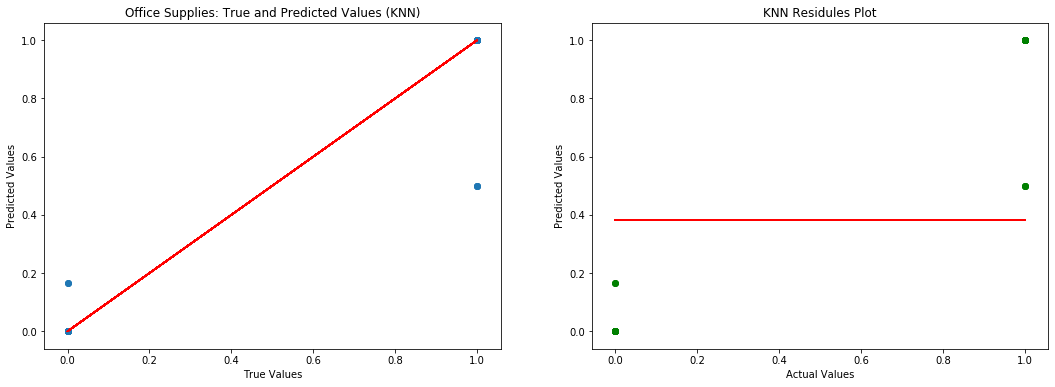

Mean Absolute Error (MAE) of the prediction is: 0.030555555555555555
Mean Squared Error (MSE) of the prediction is: 0.013425925925925926
Root Mean Squared Error of (RMSE) the prediction is: 0.11587029785896784
Mean Absolute Percentage Error (MAPE) of the prediciton is: inf
R-squared is: 0.9432040736388563


In [195]:
# Take a look at the predictions made by KNNd
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.scatter(y_test, Y_)
plt.plot(y_test, y_test, color="r")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Office Supplies: True and Predicted Values (KNN)")

plt.subplot(1,2,2)
# sns.residplot(y_test,Y_, color="g")
Y_mean_line = np.full(Y_.shape[0],[y_test.mean()])
plt.scatter(y_test,Y_,c="g")
plt.plot(y_test,Y_mean_line,c="r")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("KNN Residules Plot")

plt.show()

knn_stats = [
    "Weighted KNN",
    mean_absolute_error(y_test, Y_),
    mse(y_test, Y_),
    rmse(y_test, Y_),
    np.mean(np.abs((y_test - Y_) / y_test))*100,
    r2_score(y_test,Y_)
]

print(f"Mean Absolute Error (MAE) of the prediction is: {knn_stats[1]}")
print(f"Mean Squared Error (MSE) of the prediction is: {knn_stats[2]}")
print(f"Root Mean Squared Error of (RMSE) the prediction is: {knn_stats[3]}")
print(f"Mean Absolute Percentage Error (MAPE) of the prediciton is: {knn_stats[4]}")
print(f"R-squared is: {knn_stats[5]}")

,Quantity,Estimated Worth
Quantity,1.00000,0.02484
Estimated Worth,0.02484,1.00000


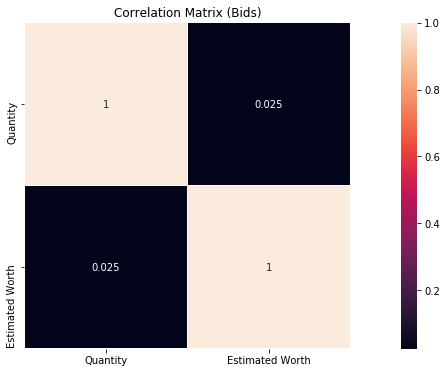

In [177]:
# %matplotlib inline
display(bids.iloc[:,:3].corr())

plt.figure(figsize=(18,6))

sns.heatmap(bids.iloc[:,:3].corr(), square=True, annot=True, linewidths=0.5)
plt.title("Correlation Matrix (Bids)")
# Fix display issues for this version of matplotlib
b,t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b,t)

plt.show();

In [196]:
comparison = [ols_stats,knn_stats]
compare_df = pd.DataFrame(comparison,columns=["Model","MAE","MSE","RMSE","MAPE","R-squared"])
compare_df

,Model,MAE,MSE,RMSE,MAPE,R-squared
0,OLS,0.414048,0.198578,0.445621,inf,0.222159
1,Weighted KNN,0.030556,0.013426,0.115870,inf,0.943204


As you can see from the visualizations these models are terrible.  While the two features are not highly correlated, they are also not very predictive.  For the Ordinary Least Squares (OLS) model only 22.21% of the change in Y can be explained by the the models features.  The K-Nearest Neighbor (KNN) is able to explain 94.32% of the change in Y using the models features.  The KNN model also perfoms better by the evaluation metrics.  MAE, MSE, and RMSE are all lower for the KNN model.